# Wigner distribution analysis

References :
- Code:
https://notebooks.azure.com/salva/projects/Digital-Image-Processing/html/002%20Image%20Frequency%20Histograms%20from%20the%20Wigner%20Distribution.ipynb
- Texture classification and retrieval through space-frequency histograms: https://www.researchgate.net/publication/321544037_Texture_classification_and_retrieval_through_space-frequency_histograms
- Image filtering and analysis through the Wigner distribution:
https://www.academia.edu/1316129/Image_filtering_and_analysis_through_the_Wigner_distribution?email_work_card=view-paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.fftpack import fft, ifft
import math

import scipy.io
import cv2 as cv
import os

## Pseudo-Wigner Distribution (PWD)

**Image analysis based on the 1D local-directional Wigner distribution** 

The analysis of digital images can be performed through the local frequency information they enclose. The task of gathering such local spatial-frequency information can be fulfilled by the use of one of the existing space/space-frequency image representations. One of the most popular space-frequency (SF) representations is the Wigner distribution (WD) [1].  **The WD has been approximated for discrete signals under the name of  pseudo-Wigner distribution (PWD)** and it has been mathematically defined as [2,3]

### $W(n,k)=2 \sum\limits_{m= -\frac{N}{2}}^{\frac{N}{2}-1} z(n+m)z^*(n-m) e^{-i2 \pi k \left(\frac{2m}{N} \right) }$   (1)

                 
In Eq.(1) the variable $z(n)$ **represents the gray value of pixel $n$ in a given image** $z$. A directional PWD may be calculated by using this equation in a tilted 1D pixel-by-pixel sliding window $L_{\theta}$  conforming a string of values $z=z(-N/2), ..., z(0), ..., z(N/2)$. The central position of the window matches exactly pixel $n$ on the image. Eq.(1) can be interpreted as the discrete Fourier transform (DFT) of the product  $r(n,m)= z(n+m)z^*(n-m)$. Here $z^*$ indicates the complex-conjugate of signal $z$ (note that $z=z^*$ for real valued images). The sum is limited to a spatial interval $(-N/2,N/2-1)$. In Eq.(1), $n$ and $k$ represent the space and frequency discrete variables respectively, and $m$ is a shifting parameter, which is also discrete. Hence,a $\theta$ oriented full pixel-wise PWD of the image can be calculated by shifting the window over all the pixels in it.  

[1] E. Wigner, "On the quantum correction for thermodynamic equilibrium",Phys. Rev. 40, 749–759 (1932)

[2] T. A. C. M. Claasen and W. F. G. Mecklenbra¨uker, "The Wigner distribution—a tool for time-frequency analysis, Parts I-III," Philips J. Res. 35, 217–250, 276–300, 372–389 (1980)

[3] K. H. Brenner, "A discrete version of the Wigner distribution function" Proc. EURASIP, Sig. Process. II: Theories Applications, pp.307–309 (1983)

## PWD functions

We now calculate the product function and its Discrete Fourier Transform in order to have the pseudo-Wigner distribution of the sequence. Hence, we define the following functions

In [2]:
def product_function(sequence):
    """
    Starting from a given sequence, this function calculates the product 
    function of the 1D pseudo-Wigner distribution of such sequence.
    """
    product = np.ones(len(sequence))
    sequence[len(sequence)-1]=sequence[0]
    for i in range(len(sequence)-1):
        product[i]= sequence[i]*sequence[len(sequence)-1-i]
    product = np.delete(product,[len(sequence)-1])
    return product

def local_wigner_function(sequence):
    """
    Starting from a given sequence, this function calculates the pseudo-Wigner
    distribution of such sequence
    """
    product =product_function(sequence)
    wigner = fft(product)
    wigner = np.real(wigner)
    H = wigner[int(len(wigner)/2):len(wigner)]
    T = wigner[0:int(len(wigner)/2)] 
    wigner = np.append(H,T)
    return wigner

We need to build a function to compute the Wigner distribution of the image. The **input required parameters** for such WD computation are: **the test image, the number of pixel in the operational 1D window and the algular orientation over the window.** 
​
The following code takes account of the orientation of the pixels in the operational window for the Wigner distribution computation.
​

In [3]:
def oriented_pattern(seq_length,angle):
    """
    This function originates a pattern that is later used for the orientation of the operational pseudo-Wigner distribution
    computation window
    seq_length: sequence length in pixels, angle: orientation in degrees
    """
    angle = np.mod(angle,180)
    # correction to set axes in the image (x: rows, y: columns) to observer cartesian coordinates x,y
    angle = np.mod((angle+90),180)
    angle =math.radians(angle)
    pi = math.pi
    h = int((seq_length/2))
    values = np.r_[float(-h):float(h+1)]
    new_positions = np.zeros([2*h+1, 2])
    for position in range(seq_length):
        if angle >= 0 and angle < pi/4:
            new_positions[position,0] = values[position]+h
            new_positions[position,1] = values[position]*math.tan(angle)+h
        elif angle >= pi/4 and angle < pi/2:
            new_positions[position,0] = values[position]*math.tan(pi/2-angle)+h
            new_positions[position,1] = values[position]+h
        elif angle >= pi/2 and angle < 3*pi/4:
            new_positions[position,0] = values[position]*math.tan(pi/2-angle)+h
            new_positions[position,1] = values[position]+h
        elif angle >= 3*pi/4 and angle <= pi:
            new_positions[position,0] = 1*values[position]+h
            new_positions[position,1] = values[position]*math.tan(angle)+h
        new_points = np.round_(new_positions)
    return new_points.astype(int)


These lines of code illustrate the arrangement of pixels in the window

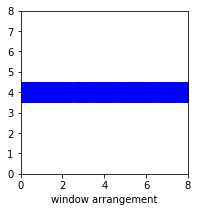

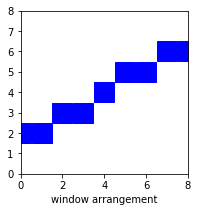

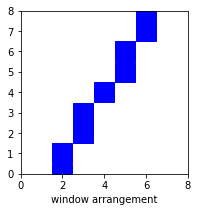

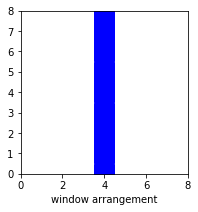

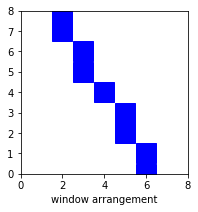

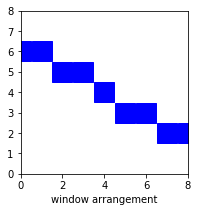

In [4]:
seq_length = 9 # 9 is commonly used
angle = [0, 30, 60, 90, 120, 150]
# correction to set axes in the image (x: rows, y: columns) to observer cartesian coordinates x,y
angle = [np.mod((a+90),180) for a in angle]
list_indices = [oriented_pattern(seq_length,a) for a in angle]
for indices in list_indices:
    plt.figure(figsize=(3,3))
    plt.plot(indices[:,0],indices[:,1],"sb",markersize=20)
    plt.xlabel("window arrangement")
    plt.xlim(0, seq_length-1) 
    plt.ylim(0, seq_length-1)
    plt.show()

## 1D pseudo-Wigner distribution

An **image of MxM pixels** originates a **discrete pseudo-Wigner distribution of MxMxN values** (N is the size of the 1D operational window for calculating the PWD). We can organize this data in **N matrices of MxM elements** and show them as N images.

In [5]:
def wigner_distribution(test_image,seq_length,angle): # seq_length must be an odd number
    """
    This application calculates the  1D pseudo-Wigner distribution of test_image image (in gray levels) , seq_length
    is the length in pixels of the operating window and it has to be an odd number (9 is a common operative value). 
    The angle variable in degrees determines the spatial orientation of the distribution.
    """
    print("calculating ...")
    # change test image to float
    test_image = np.float64(test_image)
    # determine image shape
    rows = test_image.shape[0]
    columns = test_image.shape[1]
    # determine h pixels to frame the image
    h = int((seq_length/2))
    # determine framing background image
    frame = np.ones([rows+2*h,columns+2*h])
    # insert image into the frame
    frame[h:rows+h,h:columns+h] = test_image      
    # initial wigner distribution of test image        
    distribution = np.ones([2*h,rows,columns])
    # calculations
    for row in range(h,rows+h):
        if np.mod(row,100) == 0:
            print("calculating in row ",row," ...")
            
        for column in range(h,columns+h):
            working_frame = frame[row-h:row+h+1,column-h:column+h+1]
            local_copy = working_frame.copy()
            indices = oriented_pattern(seq_length,angle)
            sequence = np.zeros(seq_length)
            for k in range(seq_length):
                sequence[k] = local_copy[indices[k,0],indices[k,1]] 
            wigner = local_wigner_function(sequence)
            distribution[:,row-h,column-h] = wigner
    return distribution

def show_wigner_frequencies(distribution):
    """
    Starting from the pseudo-Wigner distribution (distribution) of the input test image, this function gives a
    visualization of the n frequency components of such distribution and images are saved in pdf's
    """
    rows = distribution.shape[1]
    columns = distribution.shape[2]
    layers = distribution.shape[0]
    frequencies = np.zeros([layers,rows,columns])
    for layer in range(layers):
        frequency = distribution[layer,:,:]
        min_val =np.amin(frequency)
        frequency = frequency - min_val
        max_val = np.amax(frequency)
        frequency = (1/max_val)*frequency
        plt.figure()
        frequency = np.uint8(255*frequency)
        #plt.imshow(frequency, interpolation='nearest',cmap='gray')
        plt.imshow(frequency,cmap='gray')
        name = "wigner_distribution_" + str(layer) + ".pdf"
        msg = "Wigner distribution, frequency #" + str(layer)
        plt.xlabel(msg)
        #plt.savefig(name)
        frequencies[layer,:,:]= frequency
    return frequencies 

### Test : 1D PWD

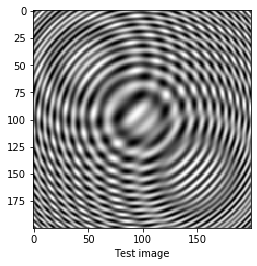

In [6]:
# Folder's path
path = 'C:\\Users\\ferna\\Desktop\\computerGeneratedHolography'
'''
file_name = 'lena_gray.png'
file_path = path + '\\' + file_name
test_image = plt.imread(file_path)
'''
#'''
file_name = 'hologram_image.mat'
file_path = path + '\\output\\' + file_name
test_image = np.loadtxt(file_path)
#'''
'''
file_name = 'reconstructed_image.jpg'
file_path = path + '\\output\\' + file_name
test_image = plt.imread(file_path)
'''
# show image version to be processed 
plt.figure(figsize =(4,4))
plt.imshow(test_image, cmap='gray')
plt.xlabel("Test image")
plt.show()


calculating ...
calculating in row  100  ...
calculating in row  200  ...
Distribution shape: (8, 200, 200)
Wall time: 10.4 s


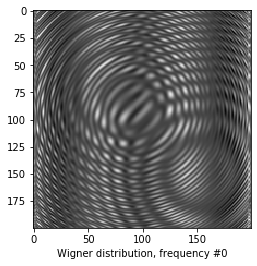

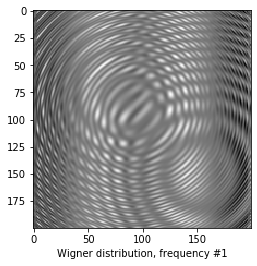

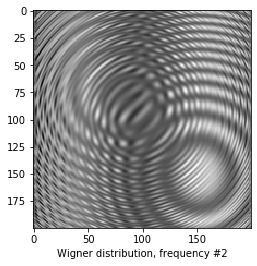

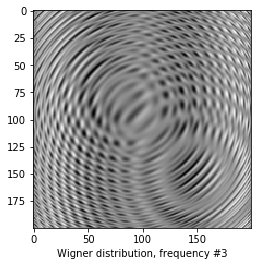

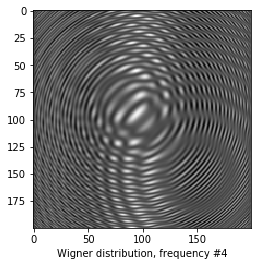

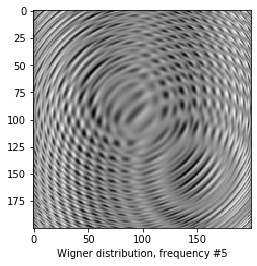

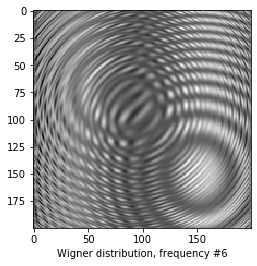

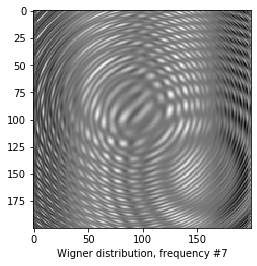

In [7]:
%%time
%matplotlib inline

# calculating the Wigner distribution
seq_length = 9 # optional odd value for the 1D wigner window
angle = 0 # optional value in degrees for 1D wigner window orientation

distribution = wigner_distribution(test_image,seq_length,angle)
print('Distribution shape: ' + str(distribution.shape))

# show distribution as a set of images
frequencies = show_wigner_frequencies(distribution)